<a href="https://www.kaggle.com/code/gnort19042003/cardiomegaly-disease-classifier-efficientnet?scriptVersionId=245068144" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Cardiomegaly Disease Classifier | EfficientNet & CNN**

<img height=1200 width=1000 src="https://entirelynourished.com/wp-content/uploads/2023/12/what-causes-an-enlarged-heart-1024x512.jpeg" />

# **Import Libraries**

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
import time

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

2025-06-12 11:25:32.225505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749727532.423174      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749727532.481142      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Trích xuất từng hình ảnh với nhãn tương ứng của nó**

In [5]:
train_data_path = '/kaggle/input/heartdataset/train/train'
filepaths =[]
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
test_data_path = '/kaggle/input/heartdataset/test/test'
filepaths =[]
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [7]:
train_df

,filepaths,label
0,/kaggle/input/heartdataset/train/train/false/1...,false
1,/kaggle/input/heartdataset/train/train/false/1...,false
2,/kaggle/input/heartdataset/train/train/false/2...,false
3,/kaggle/input/heartdataset/train/train/false/1...,false
4,/kaggle/input/heartdataset/train/train/false/2...,false
...,...,...
4433,/kaggle/input/heartdataset/train/train/true/98...,true
4434,/kaggle/input/heartdataset/train/train/true/94...,true
4435,/kaggle/input/heartdataset/train/train/true/30...,true
4436,/kaggle/input/heartdataset/train/train/true/49...,true


In [8]:
test_df

,filepaths,label
0,/kaggle/input/heartdataset/train/train/false/1...,false
1,/kaggle/input/heartdataset/train/train/false/1...,false
2,/kaggle/input/heartdataset/train/train/false/2...,false
3,/kaggle/input/heartdataset/train/train/false/1...,false
4,/kaggle/input/heartdataset/train/train/false/2...,false
...,...,...
4433,/kaggle/input/heartdataset/train/train/true/98...,true
4434,/kaggle/input/heartdataset/train/train/true/94...,true
4435,/kaggle/input/heartdataset/train/train/true/30...,true
4436,/kaggle/input/heartdataset/train/train/true/49...,true


# **Phân tách và tiền xử lý hình ảnh**

In [9]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=45)

In [10]:
img_size = (224,224)
batch_size = 16
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size ,
                                      class_mode = 'categorical' ,
                                       color_mode = 'rgb' ,
                                       shuffle = True ,
                                       batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size , 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb' ,
                                       shuffle= True,
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test ,
                                      x_col= 'filepaths' ,
                                      y_col = 'label' ,
                                      target_size = img_size , 
                                      class_mode = 'categorical' ,
                                      color_mode= 'rgb' ,
                                      shuffle = False ,
                                      batch_size = batch_size)

Found 4438 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.


# **Hiển thị mẫu hình ảnh với các lớp tương ứng của chúng**

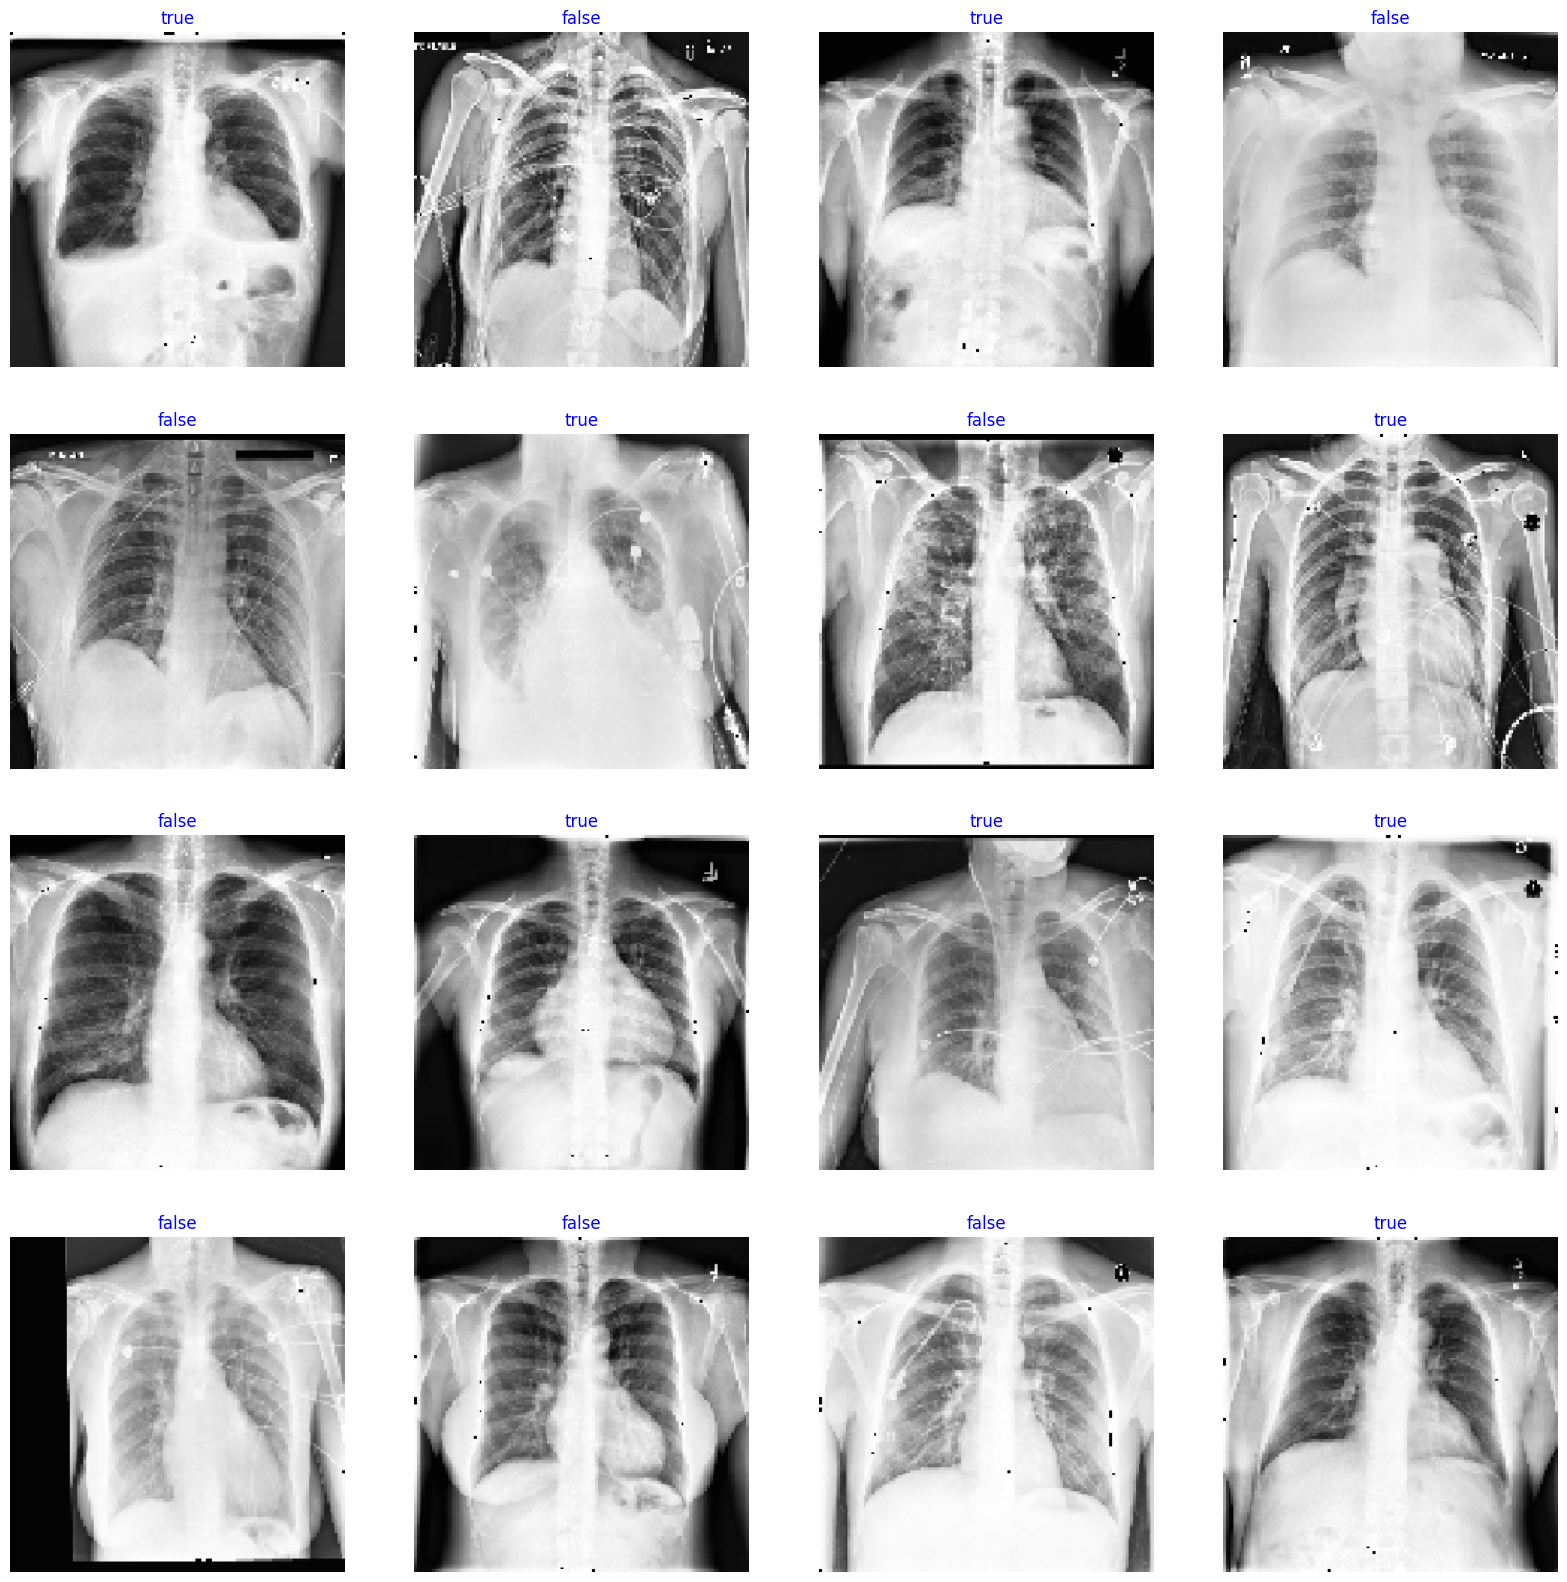

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Training**

In [12]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet',
                                                  input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),  
    Dropout(0.2),  
    Dense(num_class, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749727554.287236      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 2560)                │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2560)                │          10,240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,764,057 (247.06 MB)

 Trainable params: 64,448,210 (245.85 MB)

 Non-trainable params: 315,847 (1.20 MB)

In [13]:
Epochs = 15

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/15


I0000 00:00:1749727729.565489      93 service.cc:148] XLA service 0x79e6600019b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749727729.566379      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749727743.196586      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749727763.562778      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727763.758871      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727764.138279      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727764.3381

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5937 - loss: 1.0209

E0000 00:00:1749727954.342895      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727954.542442      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727954.911043      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727955.130598      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749727955.710746      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

278/278 ━━━━━━━━━━━━━━━━━━━━ 494s 829ms/step - accuracy: 0.5940 - loss: 1.0202 - val_accuracy: 0.7242 - val_loss: 0.5678
Epoch 2/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 112s 401ms/step - accuracy: 0.7719 - loss: 0.5582 - val_accuracy: 0.7584 - val_loss: 0.5505
Epoch 3/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 111s 401ms/step - accuracy: 0.8468 - loss: 0.3820 - val_accuracy: 0.8779 - val_loss: 0.2894
Epoch 4/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 112s 402ms/step - accuracy: 0.8955 - loss: 0.2767 - val_accuracy: 0.9558 - val_loss: 0.1073
Epoch 5/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 111s 401ms/step - accuracy: 0.9367 - loss: 0.1787 - val_accuracy: 0.9653 - val_loss: 0.0884
Epoch 6/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 111s 400ms/step - accuracy: 0.9443 - loss: 0.1346 - val_accuracy: 0.9554 - val_loss: 0.1065
Epoch 7/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 112s 401ms/step - accuracy: 0.9596 - loss: 0.1079 - val_accuracy: 0.9721 - val_loss: 0.1057
Epoch 8/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 112s 401ms/step - accuracy: 0.9666 - loss: 0.08

# **Model Evaluation**

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

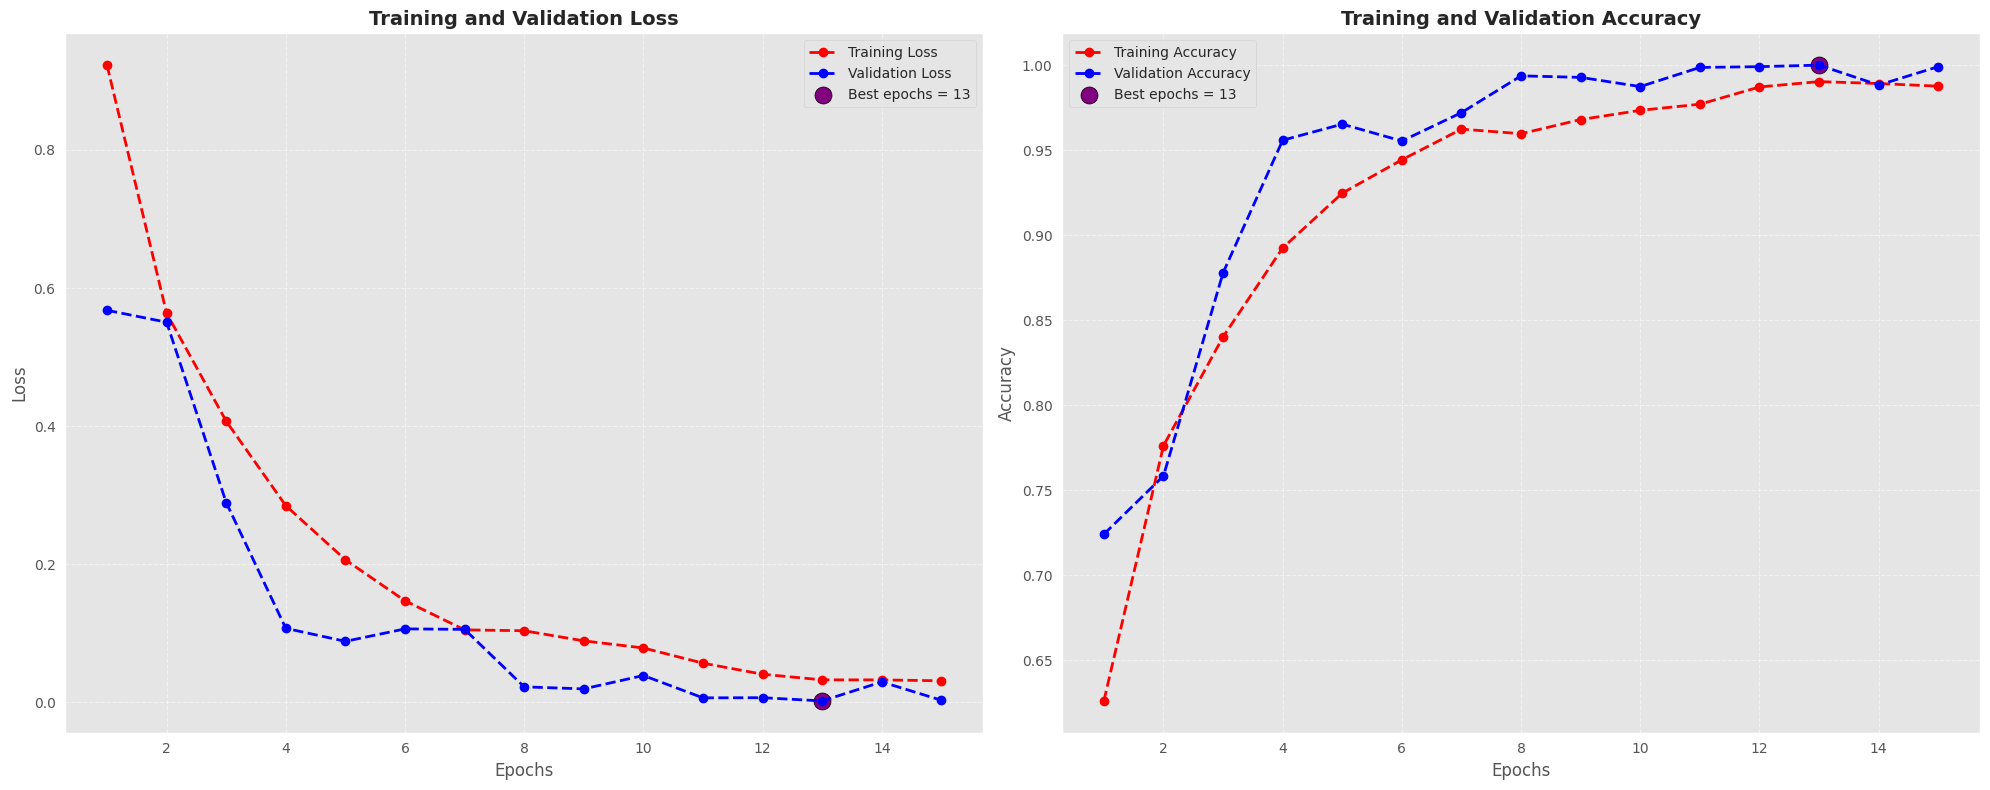

In [15]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 3.0916e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9987 - loss: 0.0029
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9873 - loss: 0.0162
Train Loss:  0.0006319505046121776
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0067635029554367065
Validation Accuracy:  0.99609375
--------------------
Test Loss:  0.005662989336997271
Test Accuracy:  0.99609375


# **Confusion Matrix**

139/139 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step


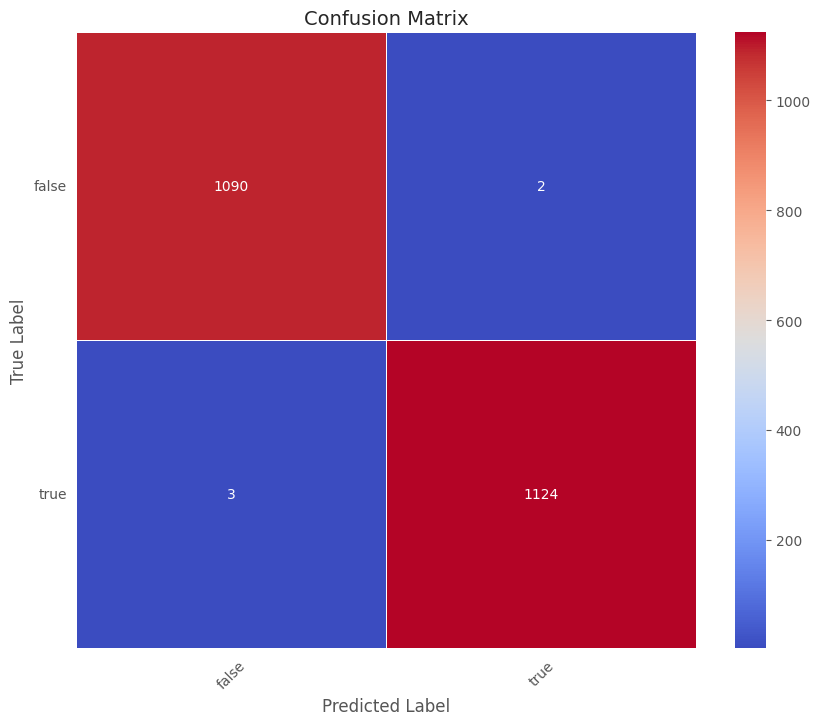

In [17]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Đánh giá mô hình

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

y_true = test_gen.labels
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step

Evaluation Metrics:
Accuracy: 0.9977
Precision: 0.9982
Recall: 0.9973
F1 Score: 0.9978


**TRAIN DATA VỚI RESNET-50 VÀ VGG16**

Bắt đầu huấn luyện các mô hình...

Đang huấn luyện ResNet50
Epoch 1/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 119s 193ms/step - accuracy: 0.6242 - loss: 0.9974 - val_accuracy: 0.5466 - val_loss: 1.9819
Epoch 2/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.7564 - loss: 0.6294 - val_accuracy: 0.8107 - val_loss: 0.4706
Epoch 3/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.8002 - loss: 0.5060 - val_accuracy: 0.7904 - val_loss: 0.4351
Epoch 4/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.8576 - loss: 0.3342 - val_accuracy: 0.8887 - val_loss: 0.2800
Epoch 5/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.9016 - loss: 0.2313 - val_accuracy: 0.9256 - val_loss: 0.1848
Epoch 6/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9266 - loss: 0.1826 - val_accuracy: 0.9202 - val_loss: 0.1849
Epoch 7/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9500 - loss: 0.1295 - val_accuracy: 0.8752 - val_loss: 0.3519
Epoch 8/15
278/278 ━━━

,Model,Test Accuracy,Test Loss,Params (Millions),Training Time (s)
0,ResNet50,0.9887,0.0324,24.1M,550.8
1,VGG16,0.7814,0.5130,14.8M,618.4


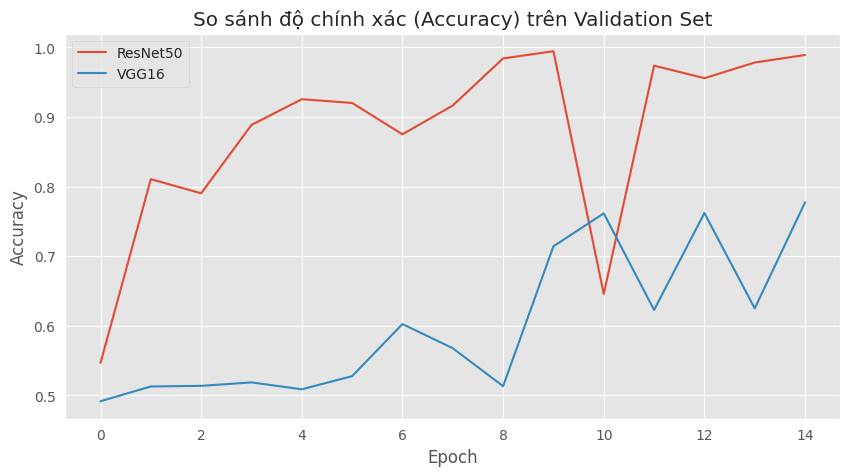


Đánh giá mô hình ResNet50
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step


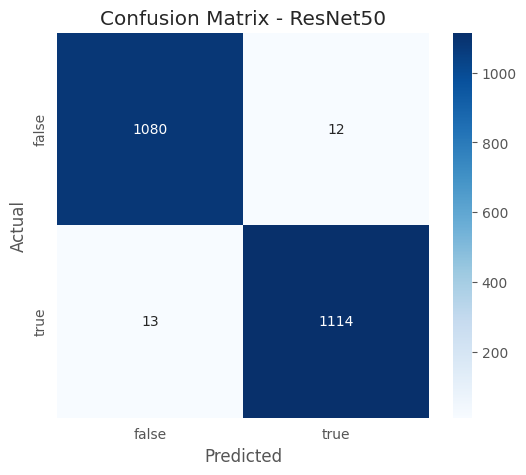


Đánh giá mô hình VGG16
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


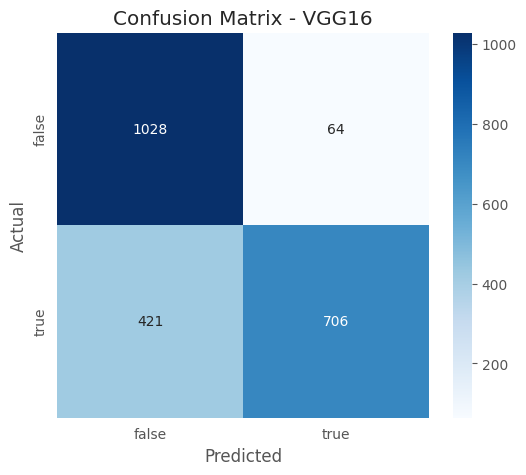

139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step

Kết quả so sánh chi tiết:


,Model,Accuracy,Precision,Recall,F1-Score,Params (Millions),Training Time (s)
0,ResNet50,0.9887,0.9887,0.9887,0.9887,24.1M,550.8
1,VGG16,0.7814,0.8148,0.7814,0.7762,14.8M,618.4


In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 15
NUM_CLASSES = len(classes)
# RESNET-50
def create_resnet50(input_shape, num_classes):
    base = ResNet50(include_top=False, weights='imagenet', 
                   input_shape=input_shape, pooling='max')
    model = Sequential([
        base,
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model
# VGG16
def create_vgg16(input_shape, num_classes):
    base = VGG16(include_top=False, weights='imagenet',
                input_shape=input_shape, pooling='max')
    model = Sequential([
        base,
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

models = {
    "ResNet50": create_resnet50((224, 224, 3), NUM_CLASSES),
    "VGG16": create_vgg16((224, 224, 3), NUM_CLASSES),
}

histories = {}
training_times = {}

print("Bắt đầu huấn luyện các mô hình...")
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Đang huấn luyện {name}")
    print(f"{'='*50}")
    
    start_time = time.time()
    histories[name] = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=valid_gen,
        verbose=1
    )
    training_times[name] = time.time() - start_time
    print(f"Hoàn thành {name} trong {training_times[name]:.2f} giây")

# Đánh giá và so sánh
results = []
for name, model in models.items():
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    trainable = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    
    results.append({
        'Model': name,
        'Test Accuracy': f"{test_acc:.4f}",
        'Test Loss': f"{test_loss:.4f}",
        'Params (Millions)': f"{(trainable + non_trainable)/1e6:.1f}M",
        'Training Time (s)': f"{training_times[name]:.1f}"
    })

print("\nKết quả so sánh:")
results_df = pd.DataFrame(results)
display(results_df.sort_values('Test Accuracy', ascending=False))

plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title('So sánh độ chính xác (Accuracy) trên Validation Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# confusion matrix
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Đánh giá mô hình {name}")
    print(f"{'='*50}")
    
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    results = []
for name, model in models.items():
    # Dự đoán trên tập test
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes
    
    # Tính các metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')  # weighted cho đa lớp
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Đếm tham số
    trainable = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    
    results.append({
        'Model': name,
        'Accuracy': f"{acc:.4f}",
        'Precision': f"{prec:.4f}",
        'Recall': f"{rec:.4f}",
        'F1-Score': f"{f1:.4f}",
        'Params (Millions)': f"{(trainable + non_trainable)/1e6:.1f}M",
        'Training Time (s)': f"{training_times[name]:.1f}"
    })

# In kết quả dạng bảng
print("\nKết quả so sánh chi tiết:")
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))